In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, make_scorer
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Load the dataset
data = pd.read_csv('/root/DATA/cleaned_final_dataset.csv')
data = data.drop(columns=['subject_id', 'icustay_id', 'hadm_id'], errors='ignore')

# Separate features and target
X = data.drop(columns=['expire_flag'])
y = data['expire_flag']
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define AUROC as the main scoring metric
scoring = make_scorer(roc_auc_score, response_method=None)

# Initialize StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    random_state=42
)

# Custom Grid Search with tqdm progress tracking
best_score = -np.inf
best_params = None
progress_bar = tqdm(total=len(list(ParameterGrid(param_grid))) * cv.get_n_splits(), desc="GridSearch Progress")

for params in ParameterGrid(param_grid):
    model = xgb.XGBClassifier(**params, random_state=42, eval_metric='logloss')
    scores = []
    
    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_val_pred = model.predict_proba(X_cv_val)[:, 1]
        scores.append(roc_auc_score(y_cv_val, y_val_pred))
        
        progress_bar.update(1)
    
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

progress_bar.close()

print(f"Best Hyperparameters: {best_params}")
print(f"Best AUROC Score (Cross-Validation): {best_score:.4f}")

# Train the model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
best_model.fit(X_train_scaled, y_train)

# Make predictions and calculate probabilities
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_train_prob = best_model.predict_proba(X_train_scaled)[:, 1]
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate confidence intervals and metrics
def bootstrap_metric_ci(metric_func, y_true, y_prob, n_bootstraps=1000):
    scores = []
    np.random.seed(42)
    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        score = metric_func(y_true.iloc[indices], y_prob[indices])
        scores.append(score)
    mean_score = np.mean(scores)
    ci_lower = mean_score - 1.96 * np.std(scores) / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * np.std(scores) / np.sqrt(len(scores))
    return f"{mean_score:.4f} ({ci_lower:.4f}, {ci_upper:.4f})"

train_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_train, y_train_prob)
test_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_test, y_test_prob)
train_auprc = average_precision_score(y_train, y_train_prob)
test_auprc = average_precision_score(y_test, y_test_prob)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Sensitivity and Specificity
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
train_sensitivity, train_specificity = calculate_sensitivity_specificity(confusion_train)
test_sensitivity, test_specificity = calculate_sensitivity_specificity(confusion_test)

# Summary table
summary_data = {
    "Metric": ["AUROC (95% CI)", "AUPRC", "F1 Score", "Accuracy", "Sensitivity", "Specificity"],
    "Training cohort": [train_auroc_ci, f"{train_auprc:.4f}", f"{train_f1:.4f}", f"{train_accuracy:.4f}", f"{train_sensitivity:.4f}", f"{train_specificity:.4f}"],
    "Testing cohort": [test_auroc_ci, f"{test_auprc:.4f}", f"{test_f1:.4f}", f"{test_accuracy:.4f}", f"{test_sensitivity:.4f}", f"{test_specificity:.4f}"]
}

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Plot confusion matrix for training and testing sets
def plot_confusion_matrix(cm, title):
    labels = ['No', 'Yes']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='viridis',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()




GridSearch Progress:  94%|█████████▍| 151/160 [01:12<00:04,  2.08it/s]


GridSearch Progress:   1%|▏         | 2/160 [00:00<00:12, 12.26it/s]

GridSearch Progress:   2%|▎         | 4/160 [00:00<00:12, 12.85it/s]

GridSearch Progress:   4%|▍         | 6/160 [00:00<00:11, 12.89it/s]

GridSearch Progress:   5%|▌         | 8/160 [00:00<00:11, 13.16it/s]

GridSearch Progress:   6%|▋         | 10/160 [00:00<00:11, 13.29it/s]

GridSearch Progress:   8%|▊         | 12/160 [00:01<00:14, 10.53it/s]

GridSearch Progress:   9%|▉         | 14/160 [00:01<00:15,  9.29it/s]

GridSearch Progress:  10%|█         | 16/160 [00:01<00:16,  8.63it/s]

GridSearch Progress:  11%|█         | 17/160 [00:01<00:16,  8.41it/s]

GridSearch Progress:  11%|█▏        | 18/160 [00:01<00:17,  8.28it/s]

GridSearch Progress:  12%|█▏        | 19/160 [00:01<00:17,  8.21it/s]

GridSearch Progress:  12%|█▎        | 20/160 [00:02<00:17,  7.82it/s]

GridSearch Progress:  13%|█▎        | 21/160 [00:02<00:17,  7.89it/s]

GridSe

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best AUROC Score (Cross-Validation): 0.7700
           Metric          Training cohort           Testing cohort
0  AUROC (95% CI)  0.8009 (0.8007, 0.8011)  0.7730 (0.7726, 0.7735)
1           AUPRC                   0.7302                   0.6912
2        F1 Score                   0.6384                   0.6034
3        Accuracy                   0.7345                   0.7131
4     Sensitivity                   0.5829                   0.5428
5     Specificity                   0.8364                   0.8277



Classification Report - Training Set:
              precision    recall  f1-score   support

          No       0.75      0.84      0.79      9588
         Yes       0.71      0.58      0.64      6447

    accuracy                           0.73     16035
   macro avg       0.73      0.71      0.71     16035
weighted avg       0.73      0.73      0.73     16035


Confusion Matrix - Training Set


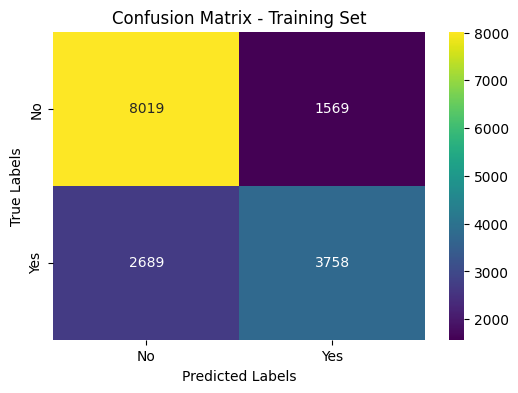

In [13]:
# Import classification_report
from sklearn.metrics import classification_report

train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print classification reports 
print("\nClassification Report - Training Set:")
print(classification_report(y_train, y_train_pred, target_names=['No', 'Yes']))

# Predictions and confusion matrix for the training set
print("\nConfusion Matrix - Training Set")
plot_confusion_matrix(train_cm, "Training Set")



Testing Set Classification Report:
              precision    recall  f1-score   support

          No       0.73      0.83      0.78      2397
         Yes       0.68      0.54      0.60      1612

    accuracy                           0.71      4009
   macro avg       0.70      0.69      0.69      4009
weighted avg       0.71      0.71      0.71      4009


Confusion Matrix - Testing Set


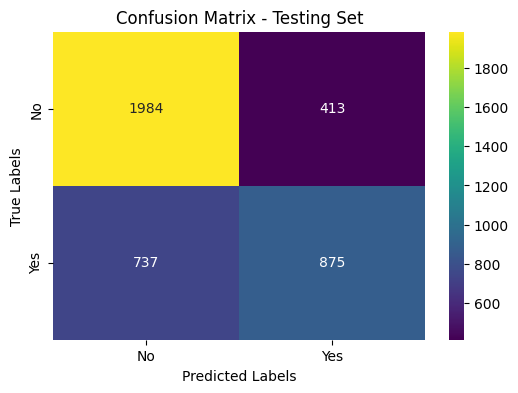

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification reports for the testing set
print("\nTesting Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No', 'Yes']))

# Compute the confusion matrix for the testing set if not already computed
test_cm_xgb = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing set
print("\nConfusion Matrix - Testing Set")
plot_confusion_matrix(test_cm, "Testing Set")


In [20]:
# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame to pair feature names with their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance and select the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 features
print("\nTop 10 Most Important Features:")
print(top_10_features)



Top 10 Most Important Features:
                                         Feature  Importance
15       admission_location_EMERGENCY ROOM ADMIT    0.190260
0                                      age_years    0.128495
16  admission_location_PHYS REFERRAL/NORMAL DELI    0.108417
14  admission_location_CLINIC REFERRAL/PREMATURE    0.059916
4                                      gcsverbal    0.059370
17  admission_location_TRANSFER FROM HOSP/EXTRAM    0.054978
6                              bloodureanitrogen    0.054881
12                      admission_type_EMERGENCY    0.049127
3                                       gcsmotor    0.046975
13                         admission_type_URGENT    0.034212


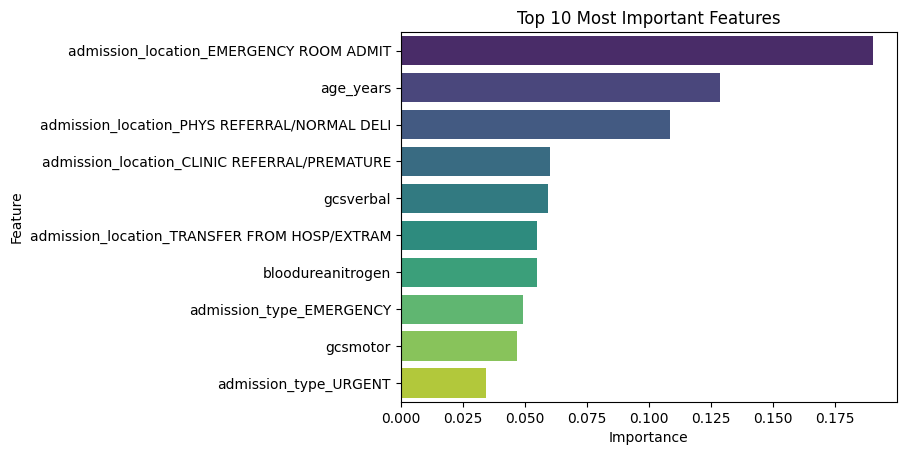

In [23]:
# Plot the top 10 most important features without setting hue, with legend=False
import warnings
warnings.filterwarnings("ignore")

sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.legend([], [], frameon=False)  # Explicitly disable legend if it appears
plt.show()


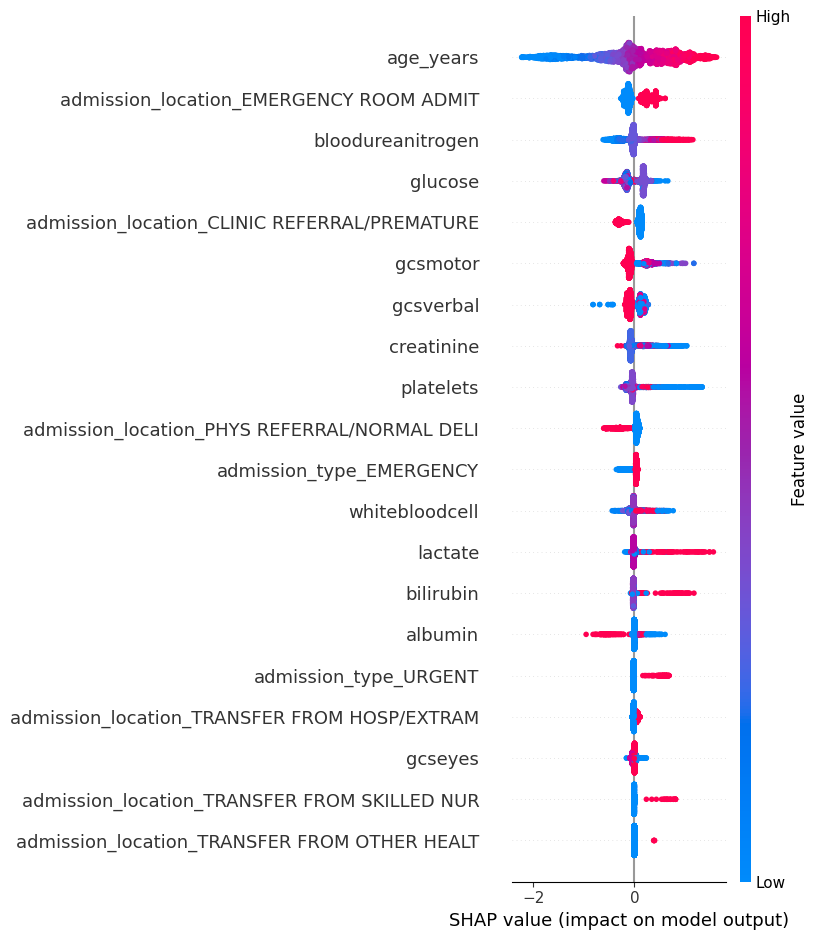

In [16]:
import shap
import matplotlib.pyplot as plt

# 创建 SHAP Explainer，使用训练集数据来解释模型
explainer = shap.Explainer(best_model, X_train_scaled)

# 计算测试集的 SHAP 值
shap_values = explainer(X_test_scaled)

# 生成 SHAP 摘要图
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)


In [17]:
import pandas as pd

# Save the training set predictions and true labels
train_results = pd.DataFrame({
    "True_Label": y_train,
    "Predicted_Probability": y_train_prob
})
train_results.to_csv('/root/DATA/train_results_xgboost.csv', index=False)

# Save the testing set predictions and true labels
test_results = pd.DataFrame({
    "True_Label": y_test,
    "Predicted_Probability": y_test_prob
})
test_results.to_csv('/root/DATA/test_results_xgboost.csv', index=False)

print("Predicted probabilities and true labels for training and testing sets have been saved.")


Predicted probabilities and true labels for training and testing sets have been saved.
